### Problem:
#### An e-commerce startup wants to know if a new checkout funnel (B) outperforms the old one (A).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

#### Step 1 
- Simulate click‐through data (visits vs. purchases) for A and B.

In [2]:
n_A = 15000
n_B = 15000
P_A = 0.12
P_B = 0.14

In [3]:
np.random.seed(42)

In [4]:
success_A = np.random.binomial(n_A,P_A)
success_B = np.random.binomial(n_B,P_B)

In [5]:
print("Success of A = ",success_A)
print("Success of B = ",success_B)

Success of A =  1763
Success of B =  2135


___________________________________________________

#### Step 2
- Calculate conversion rates and 95% confidence intervals.

We are ,aking a function for calculating the the 95% confidence interval and conversion rates

In [6]:
def proportion(success,n,alpha=0.05):
    p_hat = success/n
    z = stats.norm.ppf(1 - alpha/2)
    se = np.sqrt(p_hat * (1- p_hat)/n)
    return p_hat,p_hat - z*se,p_hat+z*se

In [7]:
p_A_hat,ci_low_A,ci_high_A = proportion(success_A,n_A)
p_B_hat,ci_low_B,ci_high_B = proportion(success_B,n_B)

In [8]:
print(f"Conversion Rate of A : {p_A_hat:.3f}\nConversion Rate of B : {p_B_hat:.3f}")
print(f"Confidence Interval of A : ({ci_low_A:.3f},{ci_high_A:.3f})")
print(f"Confidence Interval of B : ({ci_low_B:.3f},{ci_high_B:.3f})")

Conversion Rate of A : 0.118
Conversion Rate of B : 0.142
Confidence Interval of A : (0.112,0.123)
Confidence Interval of B : (0.137,0.148)


Here as we can see B has a quiet higher conversion rates than A

___________________________________________________

#### Step 4
- Plot conversion rates with error bars.

Here we are plotting the conversion rates with the errors. By plotting we can be more clear about the difference 

In [ ]:
# A results DataFrame for help in ploting and summarizing what we have find tin now
results = pd.DataFrame({
    'Variant': ['A','B'],
    'Visitors': [n_A,n_B],
    'Conversions': [success_A,success_B],
    'CR(p_hat)': [p_A_hat,p_B_hat],
    'CI Lower (95%)':[ci_low_A, ci_low_B],
    'CI Upper (95%)':[ci_high_A,ci_high_B],
})

In [10]:
results

,Variant,Visitors,Conversions,CR(p_hat),CI Lower (95%),CI Upper (95%)
0,A,15000,1763,0.117533,0.112379,0.122687
1,B,15000,2135,0.142333,0.136742,0.147925


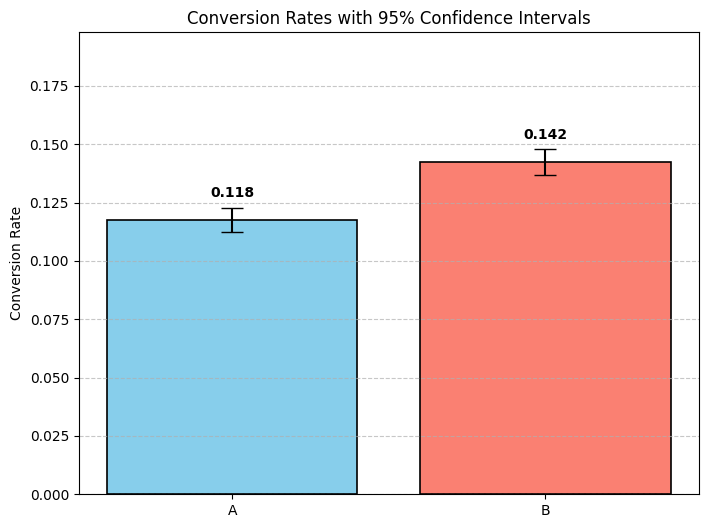

In [11]:
plt.figure(figsize=(8, 6))

error_lower = results['CR(p_hat)'] - results['CI Lower (95%)']
error_upper = results['CI Upper (95%)'] - results['CR(p_hat)']
error = [error_lower, error_upper]

plt.bar(
    results['Variant'],
    results['CR(p_hat)'],
    yerr=error,
    capsize=8,
    color=['skyblue', 'salmon'],
    edgecolor='black',
    linewidth=1.2
)

plt.ylabel('Conversion Rate')
plt.title('Conversion Rates with 95% Confidence Intervals')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(results['CI Upper (95%)']) + 0.05)

for idx, row in results.iterrows():
    plt.text(
        row['Variant'],
        row['CR(p_hat)'] + 0.01,
        f"{row['CR(p_hat)']:.3f}",
        ha='center',
        fontweight='bold'
    )

plt.show()


Here we can clearly see there is quiet a differnce between B and A 

#### Step 4:
- Perform a two‐proportion z‐test to see if B beats A.

In [16]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([success_B,success_A])
nobs = np.array([n_A,n_B])
z_stat, p_value = proportions_ztest(count,nobs,alternative = 'larger')
print(f"Z-statistic : {z_stat:.3f}")
print(f"P-value     : {p_value}")

Z-statistic : 6.388
P-value     : 8.418955796461037e-11


**The p - value is very small** hence we can say from this study that B is performing significantly better than A

In [13]:
if p_value < 0.05:
    print("Reject H0: Variant B have significantly higher conversion rate then Varient A")
else:
    print("Fai to reject H0: Variant B does not have higher conversion rate then Varient A")

Reject H0: Variant B have significantly higher conversion rate then Varient A


But this is not enough we beed to see the performance of both A and B in Real time

#### Step 5

- Real-Time Monitoring & Sequential Testing

In [14]:
import time

np.random.seed(1)

true_p_A,true_p_B = 0.12,0.14
batch_size =200
n_batches = 60

n_visits_A = n_visits_B = 0
n_succ_A = n_succ_B = 0

batches = []
p_values = []
lifts = []

SD = 0
NSD = 0
for batch in range(1,n_batches+1):
    new_A = np.random.binomial(batch_size,true_p_A)
    new_B = np.random.binomial(batch_size,true_p_B)
    
    n_visits_A += batch_size
    n_visits_B += batch_size
    n_succ_A += new_A
    n_succ_B += new_B
    
    cr_A = n_succ_A/n_visits_A
    cr_B = n_succ_B/n_visits_B
    lift = cr_B - cr_A
    
    count = np.array([n_succ_B,n_succ_A])
    nobs = np.array([n_visits_B,n_visits_A])
    z_stat, p_value = proportions_ztest(count,nobs,alternative = 'larger')
    
    batches.append(batch)
    p_values.append(p_value)
    lifts.append(lift)
    
print(f"Batch {batch}/{n_batches}")
print(f" Variant A: {n_visits_A} visits, {n_succ_A} buys -> CR = {cr_A:.3%}")
print(f" Variant B: {n_visits_B} visits, {n_succ_B} buys -> CR = {cr_B:.3%}")
print(f" Observed lift: {lift:.3%}")
print(f" z-stat = {z_stat:.2f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print(" ✅ Significant lift detected (p<0.05).")
else:
    print(" ❌ No significant lift yet.")

Batch 60/60
 Variant A: 12000 visits, 1390 buys -> CR = 11.583%
 Variant B: 12000 visits, 1722 buys -> CR = 14.350%
 Observed lift: 2.767%
 z-stat = 6.38, p-value = 0.0000
 ✅ Significant lift detected (p<0.05).


Here is the plot for better understanding 

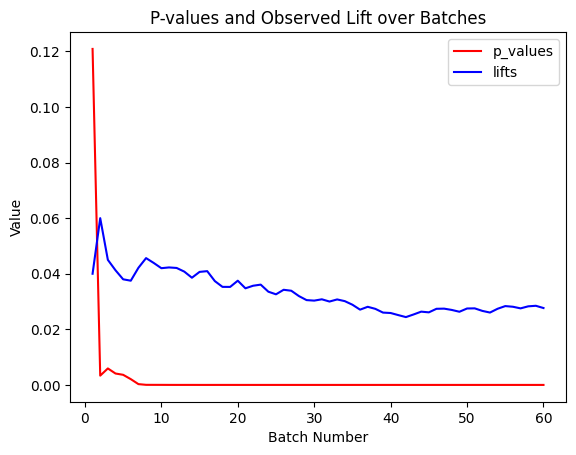

In [15]:
plt.plot(batches,p_values,'-r',label = 'p_values')
plt.plot(batches,lifts,'-b',label = 'lifts')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Value')
plt.title('P-values and Observed Lift over Batches')

plt.show()

#### Explaination of plot

- The plot shows how the p-values and the observed lift change over the 60 batches in our simulation.

- The red line represents the p-values. It quickly drops and stabilizes at zero, indicating that the difference in conversion rates between Variant A and Variant B becomes statistically significant

- The blue line represents the observed lift, which measures the improvement of Variant B over Variant A.

#### Final conclusion

This simulation was designed to evaluate whether Variant B consistently outperforms Variant A in terms of conversion rate across multiple test batches.

By incrementally adding new data, we were able to calculate the conversion rates and lift between the two variants over time. 
At each step, we also conducted a statistical test (the z-test for proportions) to assess whether any observed lift was significant.

The final results show that Variant B achieved a **conversion rate of 14.350%**, while Variant A had a **conversion rate of 11.583% with a significant lift of 2.767%**. 
Which makes the p-value zero, indicating that the observed difference is significant.
